# HRRR Map Templates
Brian Blaylock  
September 27, 2017

Creates various maps of HRRR variables available in the [HRRR Archive](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/hrrr_FAQ.html) on Pando at the University of Utah.

- Utilizes `the get_hrrr_variable()` function to extract the variable from Pando
    - Requires `pygrib`
- The map object is created with the `draw_CONUS_HRRR_map()` function
    - Requires `Basemap`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import numpy as np

#Import my custom functions: https://github.com/blaylockbk/pyBKB_v2
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2/')
from BB_downloads.HRRR_S3 import get_hrrr_variable
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_cmap.terrain_colormap import *
from BB_cmap.terrain_colormap import terrain_cmap_256
from BB_cmap.landuse_colormap import LU_MODIS21

In [2]:
# Reassign Plotting Defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

Specify a few constants we will reuse throughout this demo

In [3]:
# Specify the date and the hour
DATE = datetime(2018, 1, 22, 0)

# Make map object
m = draw_CONUS_HRRR_map()

#### How to use the `get_hrrr_variable()` function
- You are only required to specify the date and variable. Other variable defaults are shown below.   
- The variable string must include the variable abbreviation and level to match a line in the .idx files ([example](https://api.mesowest.utah.edu/archive/HRRR//oper/sfc/20170925/hrrr.t00z.wrfsfcf00.grib2.idx)).  
    For example:
    - **`'TMP:surface'`** will get the temperature at the surface
    - **`'TMP:2 m'`** will get the 2 meter temperature
    - **`'DPT:500 mb'`** will get the 500 mb dew point


In [4]:
H = get_hrrr_variable(DATE,              # Date of model start hour, as python datetime object
                      'TMP:surface',     # Variable name and level, as defined in .idx file
                      fxx=0,             # Forecast hour
                      model='hrrr',      # hrrr or hrrrAK or hrrrX
                      field='sfc',       # sfc or prs or subh or nat
                      removeFile=True,   # deletes the downloaded grib2 file on exit
                      value_only=False,  # only returns the values, not the lat/lon arrays, etc.
                      verbose=True,      # prints some extra details from the function
                      outDIR='./')       # directory to save the downloaded grib2 files
print '\nAvailable keys in H:', H.keys()

./temp_2018012200_f00_TMP.grib2

-----------------------------------------------------------------------
!! Hey! You are requesting a date that is not on the Pando archive  !!
!! That's ok, I'll redirect you to the NOMADS server. :)            !!
-----------------------------------------------------------------------

matched a variable 47:31330091:d=2018012200:TMP:surface:anl:

range: 31330091 32708199

Available keys in H: ['lon', 'value', 'msg', 'valid', 'lat', 'anlys']


H is a dictionary of data from the grib2 file:

    H['lon']   - a 2D np.array of the grid longitude  
    H['lat']   - a 2D np.array of the grid latitude  
    H['value'] - a 2D np.array of the grid value of the variable requested
    H['anlys'] - a datetime object of the model start time (analysis time) 
    H['valid'] - a datetime object of the model valid time (analysis time + forecast time)
    H['msg']   - the grib2 message for the variable item (The variable's units are found here)

## 700 MB Temperature
Contoured data

./temp_2017092500_f00_TMP.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 17:10032923:d=2017092500:TMP:700 mb:anl

range: 10032923 10581986
1:Temperature:K (instant):lambert:isobaricInhPa:level 70000 Pa:fcst time 0 hrs:from 201709250000


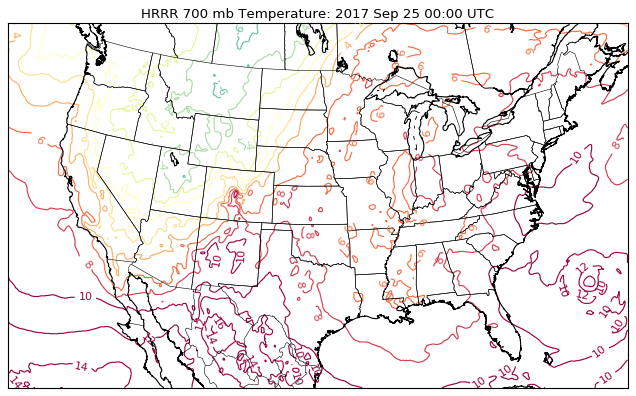

In [5]:
H = get_hrrr_variable(DATE, variable='TMP:700 mb')
print H['msg']

CS = m.contour(H['lon'], H['lat'], H['value']-273.15, 
                latlon=True,
                levels=range(-30,30,2),
                cmap='Spectral_r', vmin=-10, vmax=10)
plt.clabel(CS, inline=1, fmt='%2.f')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 700 mb Temperature: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## Simulated Composite Reflectivity
pcolormesh with masked values

./temp_2017092500_f00_REF.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 1:0:d=2017092500:REFC:entire atmosphere:anl

range: 0 456265
1:Maximum/Composite radar reflectivity:dB (instant):lambert:unknown:level 0 10:fcst time 0 hrs:from 201709250000


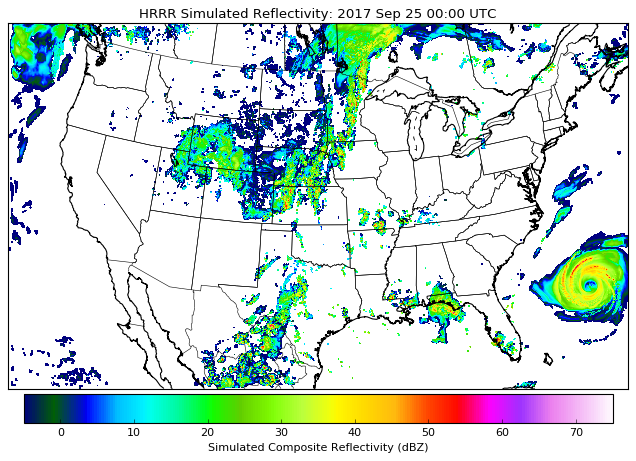

In [6]:
H = get_hrrr_variable(DATE, variable='REFC:entire')
print H['msg']

dBZ = H['value']
dBZ = np.ma.array(dBZ)
dBZ[dBZ == -10] = np.ma.masked
m.pcolormesh(H['lon'], H['lat'], dBZ, 
             cmap='gist_ncar',
             vmax=75, vmin=-5,
             latlon=True)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Simulated Composite Reflectivity (dBZ)')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR Simulated Reflectivity: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## 500 mb Heights
contour with lines same color

./temp_2017092500_f00_HGT.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 11:5941543:d=2017092500:HGT:500 mb:anl

range: 5941543 6636196
1:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 50000 Pa:fcst time 0 hrs:from 201709250000


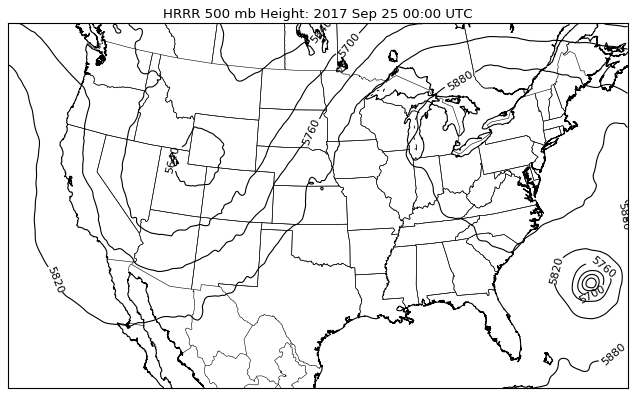

In [7]:
H = get_hrrr_variable(DATE, variable='HGT:500 mb')
print H['msg']

CS = m.contour(H['lon'], H['lat'], H['value'], 
                latlon=True,
                levels=range(5040, 6181, 60),
                colors='k')
plt.clabel(CS, inline=1, fmt='%2.f')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 500 mb Height: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## Sea Level Pressure
overlay contour on pcolormesh

./temp_2017092500_f00_MSL.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 37:22828901:d=2017092500:MSLMA:mean sea level:anl

range: 22828901 23445628
1:MSLP (MAPS System Reduction):Pa (instant):lambert:meanSea:level 0:fcst time 0 hrs:from 201709250000


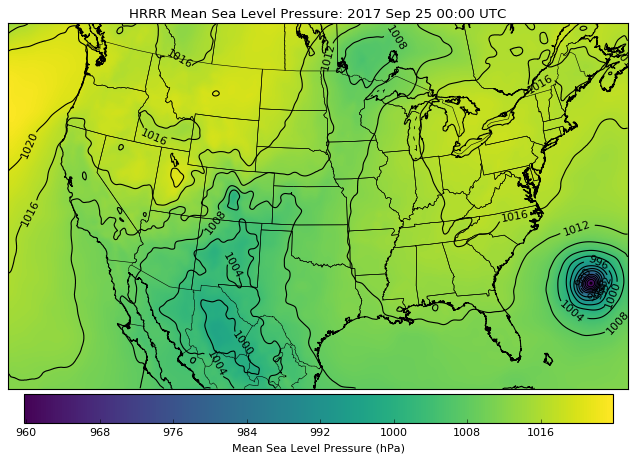

In [8]:
H = get_hrrr_variable(DATE, variable='MSLMA:mean sea level')
print H['msg']

CS = m.contour(H['lon'], H['lat'], H['value']/100., 
               latlon=True,
               levels=range(952, 1200, 4),
               colors='k')
plt.clabel(CS, inline=1, fmt='%2.f')

m.pcolormesh(H['lon'], H['lat'], H['value']/100., 
               latlon=True, cmap='viridis')

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('Mean Sea Level Pressure (hPa)')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR Mean Sea Level Pressure: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## 2 m Temperature
pcolormesh

./temp_2017092500_f00_TMP.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 54:33406920:d=2017092500:TMP:2 m above ground:anl

range: 33406920 34679071
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201709250000


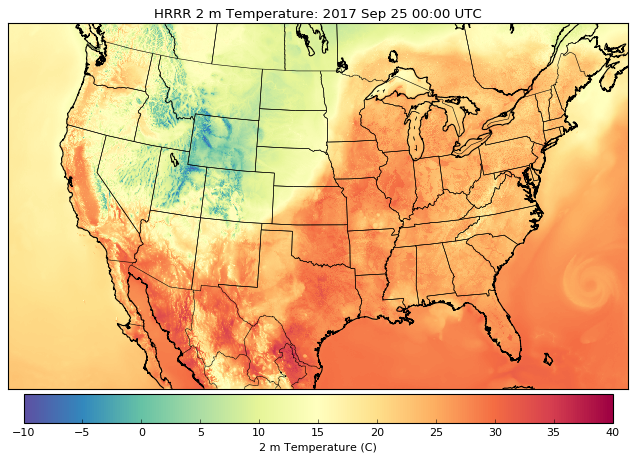

In [9]:
H = get_hrrr_variable(DATE, variable='TMP:2 m')
print H['msg']

# Remember to convert units from Kelvin to C
m.pcolormesh(H['lon'], H['lat'], H['value']-273.15, 
             latlon=True, cmap='Spectral_r',
             vmax=40, vmin=-10)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('2 m Temperature (C)')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 2 m Temperature: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## Precipitation
pcolormesh for a forecast

./temp_2017092500_f06_APC.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 64:48684187:d=2017092500:APCP:surface:0-6 hour acc fcst

range: 48684187 49294499
matched a variable 69:49414921:d=2017092500:APCP:surface:5-6 hour acc fcst

range: 49414921 49892765
1:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 5-6 hrs (accum):from 201709250000


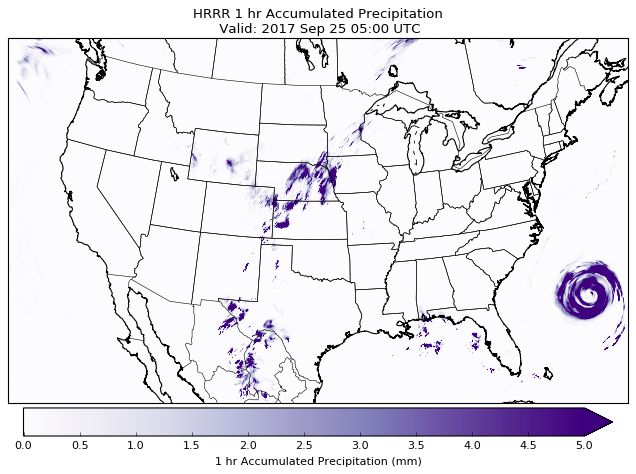

In [10]:
H = get_hrrr_variable(DATE, variable='APCP:surface', fxx=6)
print H['msg'] # note: kg/m^2 is mm

m.pcolormesh(H['lon'], H['lat'], H['value'], 
             latlon=True, cmap='Purples',
            vmax=5, vmin=0)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95, extend='max')
cb.set_label('1 hr Accumulated Precipitation (mm)')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 1 hr Accumulated Precipitation\n Valid: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## Wind
Need to get two variables, u and v direction, and derive wind speed and direction

#### 10 m Wind

./temp_2017092500_f00_UGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 59:39997040:d=2017092500:UGRD:10 m above ground:anl

range: 39997040 41138946
./temp_2017092500_f00_VGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 60:41138947:d=2017092500:VGRD:10 m above ground:anl

range: 41138947 42295003
1:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 hrs:from 201709250000
1:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 hrs:from 201709250000


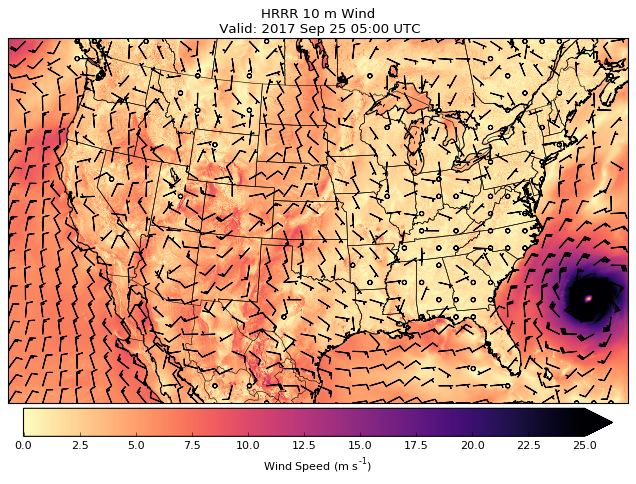

In [11]:
Hu = get_hrrr_variable(DATE, variable='UGRD:10 m')
Hv = get_hrrr_variable(DATE, variable='VGRD:10 m')
print Hu['msg'] # note: kg/m^2 is mm
print Hu['msg'] # note: kg/m^2 is mm

# Calculate Wind Speed from u and v
spd = wind_uv_to_spd(Hu['value'], Hv['value'])

# There will be too many barbs if we plot all of them, so we will thin them out
thin = 50

# Plot the Wind Speed as the underlying color
m.pcolormesh(Hu['lon'], Hu['lat'], spd, latlon=True, cmap='magma_r', vmax=25, vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95, extend='max')
cb.set_label(r'Wind Speed (m s$\mathregular{^{-1}}$)')

# Plot the Barbs at the thinned resolution
m.barbs(Hu['lon'][::thin,::thin], H['lat'][::thin,::thin], Hu['value'][::thin,::thin], Hv['value'][::thin,::thin],
        latlon=True,
        length=5,
        barb_increments={'half': 2.5,'full': 5,'flag':25})

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 10 m Wind\n Valid: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

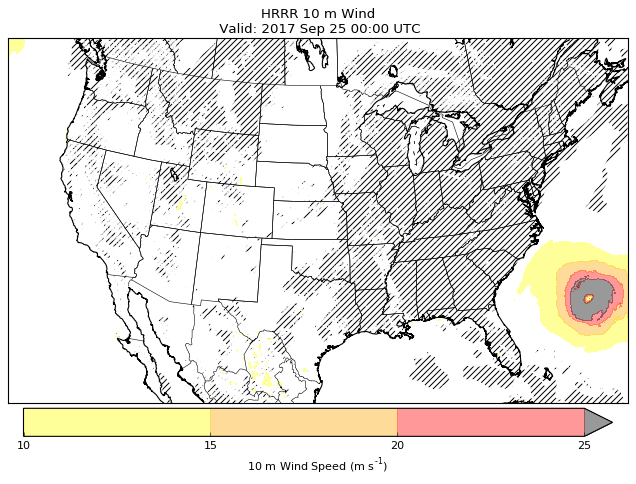

In [12]:
# Shade high wind speeds
m.contourf(Hu['lon'], Hu['lat'], spd,
           levels=[10, 15, 20, 25],
           colors=('yellow', 'orange', 'red', 'black'),
           alpha=.4,
           extend='max',
           latlon=True)
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.95)
cb.set_label(r'10 m Wind Speed (m s$\mathregular{^{-1}}$)')

# Hatch area where winds are less than 2.5 ms-1
m.contourf(Hu['lon'], Hu['lat'], spd,
           levels=[0, 2.5],
           hatches=['////'],
           colors='none',
           latlon=True)

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 10 m Wind\n Valid: %s' % Hu['valid'].strftime('%Y %b %d %H:%M UTC'))

#### 500 mb wind

./temp_2017092500_f00_UGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 14:8161675:d=2017092500:UGRD:500 mb:anl

range: 8161675 8744665
./temp_2017092500_f00_VGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 15:8744666:d=2017092500:VGRD:500 mb:anl

range: 8744666 9340667
1:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 50000 Pa:fcst time 0 hrs:from 201709250000
1:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 50000 Pa:fcst time 0 hrs:from 201709250000


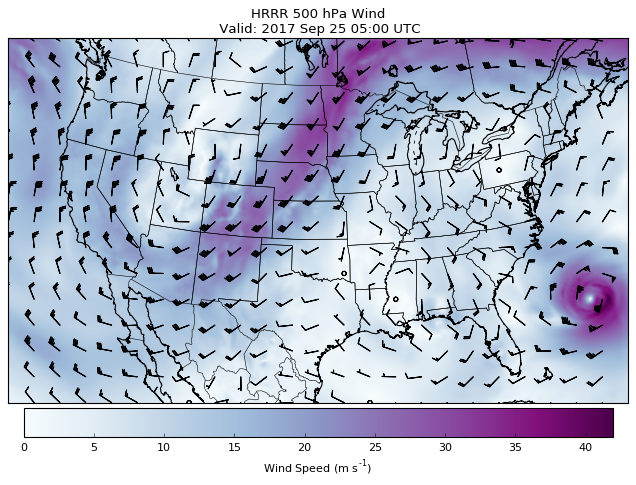

In [13]:
Hu = get_hrrr_variable(DATE, variable='UGRD:500 mb')
Hv = get_hrrr_variable(DATE, variable='VGRD:500 mb')
print Hu['msg'] # note: kg/m^2 is mm
print Hu['msg'] # note: kg/m^2 is mm

# Calculate Wind Speed from u and v
spd = wind_uv_to_spd(Hu['value'], Hv['value'])

# There will be too many barbs if we plot all of them, so we will thin them out
thin = 75

# Plot the Wind Speed as the underlying color
m.pcolormesh(Hu['lon'], Hu['lat'], spd, latlon=True, cmap='BuPu', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label(r'Wind Speed (m s$\mathregular{^{-1}}$)')

# Plot the Barbs at the thinned resolution
m.barbs(Hu['lon'][::thin,::thin], H['lat'][::thin,::thin], Hu['value'][::thin,::thin], Hv['value'][::thin,::thin],
        latlon=True,
        length=5,
        barb_increments={'half': 2.5,'full': 5,'flag':25})

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 500 hPa Wind\n Valid: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## Terrain with Water
Often good to use the land/water mask to mask out water. Also, use my custom terrain colormap.

./temp_2017092500_f00_HGT.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 46:28144725:d=2017092500:HGT:surface:anl

range: 28144725 30381073
./temp_2017092500_f00_LAN.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 127:102031228:d=2017092500:LAND:surface:anl

range: 102031228 102100323
1:Orography:m (instant):lambert:surface:level 0:fcst time 0 hrs:from 201709250000
1:Land-sea mask:(0 - 1) (instant):lambert:surface:level 0:fcst time 0 hrs:from 201709250000


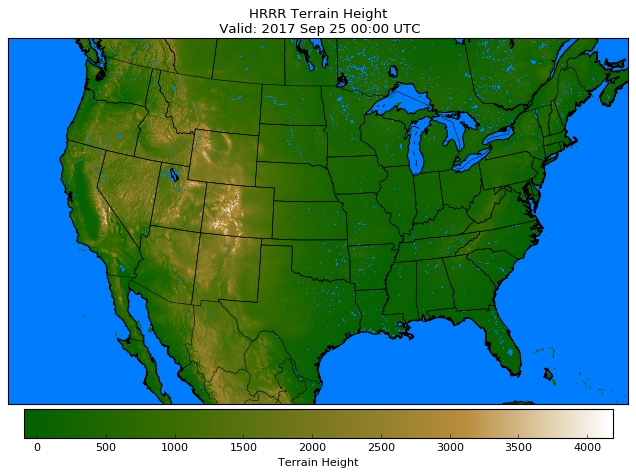

In [14]:
Ht = get_hrrr_variable(DATE, variable='HGT:surface') # Terrain
Hl = get_hrrr_variable(DATE, variable='LAND:surface') # Land/Water Mask
print Ht['msg']
print Hl['msg']

TerrainWater = Ht['value']
TerrainWater[Hl['value']==0] = -99

m.pcolormesh(Ht['lon'], Ht['lat'], TerrainWater,
             cmap=terrain_cmap_256(),
             latlon=True)
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.95)
cb.set_label('Terrain Height')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR Terrain Height\n Valid: %s' % Ht['valid'].strftime('%Y %b %d %H:%M UTC'))

## Landuse Categories

./temp_2017092500_f00_VGT.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 78:48795828:d=2017092500:VGTYP:surface:anl

range: 48795828 49656363
1:Vegetation Type:Integer(0-13) (instant):lambert:surface:level 0:fcst time 0 hrs:from 201709250000


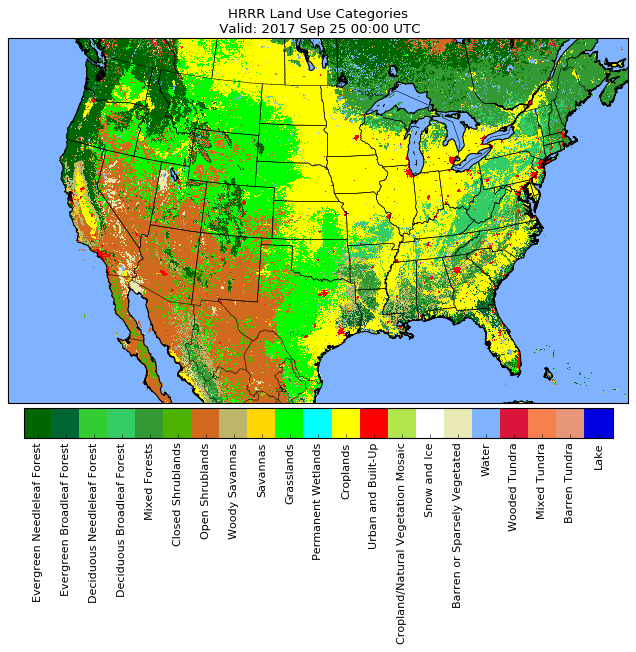

In [15]:
H = get_hrrr_variable(DATE, variable='VGTYP:surface')
print H['msg']

cm, labels = LU_MODIS21()

m.pcolormesh(Ht['lon'], Ht['lat'], H['value'],
             cmap=cm, vmin=1, vmax=len(labels) + 1,
             latlon=True)
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.95)
cb.set_ticks(np.arange(0.5, len(labels) + 1))
cb.ax.set_xticklabels(labels, rotation=90)
    
m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR Land Use Categories\n Valid: %s' % Ht['valid'].strftime('%Y %b %d %H:%M UTC'))

## Freezing Surface Temperature Contour

./temp_2017100219_f00_TMP.grib2

-----------------------------------------------------------------------
!! Hey! You are requesting a date that is not on the Pando archive  !!
!! That's ok, I'll redirect you to the NOMADS server. :)            !!
-----------------------------------------------------------------------

matched a variable 54:34391436:d=2017100219:TMP:2 m above ground:anl:

range: 34391436 35639631
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710021900


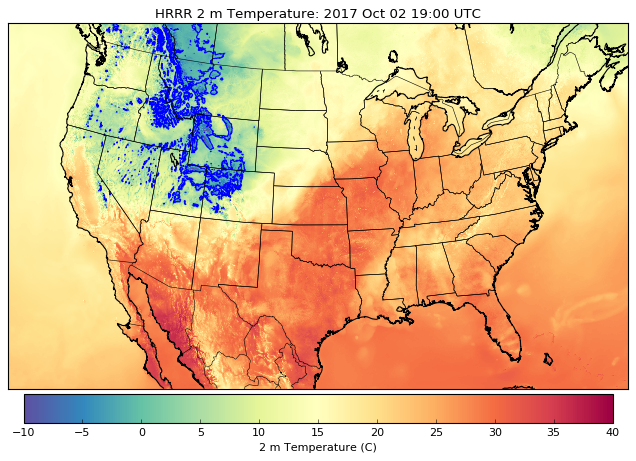

In [18]:
H = get_hrrr_variable(datetime(2017, 10, 2, 19), variable='TMP:2 m')
print H['msg']

# Remember to convert units from Kelvin to C
m.contour(H['lon'], H['lat'], H['value']-273.15, 
          latlon=True, colors='blue',
          levels=[0])

m.pcolormesh(H['lon'], H['lat'], H['value']-273.15, 
             latlon=True, cmap='Spectral_r',
             vmax=40, vmin=-10)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('2 m Temperature (C)')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR 2 m Temperature: %s' % H['valid'].strftime('%Y %b %d %H:%M UTC'))

## Difference Plots
2 m temperature analysis versus the 18 hour forecast

./temp_2017101000_f00_TMP.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 54:32968209:d=2017101000:TMP:2 m above ground:anl

range: 32968209 34215398
./temp_2017100906_f18_TMP.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 54:36617861:d=2017100906:TMP:2 m above ground:18 hour fcst

range: 36617861 37887879
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201710100000 2017-10-10 00:00:00
1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 18 hrs:from 201710090600 2017-10-10 00:00:00


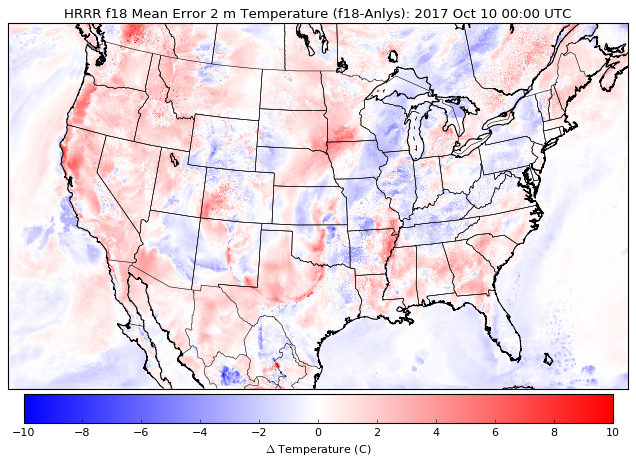

In [22]:
# To match the valid time for the forecast fxx and the analysis, 
#   we'll need to subtract the number of forecast hours from the analysis date.
DATE = datetime(2017, 10, 10, 0)
fxx = 18

# HRRR Analysis
H = get_hrrr_variable(DATE, variable='TMP:2 m')

# HRRR Forecast
Hf = get_hrrr_variable(DATE-timedelta(hours=fxx), variable='TMP:2 m', fxx=fxx)

print H['msg'], H['valid']
print Hf['msg'], Hf['valid']

# Calculate the difference between the HRRR analysis and HRRR forecast (fxx-anlys)
#   so that the red shows where the forecast is hot and blue shows where forecast
#   is cold.
diff = Hf['value']-H['value']

m.pcolormesh(H['lon'], H['lat'], diff, 
             latlon=True, cmap='bwr',
             vmax=10, vmin=-10)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label(r'$\Delta$ Temperature (C)')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR f%02d Mean Error 2 m Temperature (f%02d-Anlys): %s' % (fxx, fxx, H['valid'].strftime('%Y %b %d %H:%M UTC')))

Difference in wind speed

./temp_2017101000_f00_UGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 59:39379290:d=2017101000:UGRD:10 m above ground:anl

range: 39379290 40498723
./temp_2017101000_f00_VGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 60:40498724:d=2017101000:VGRD:10 m above ground:anl

range: 40498724 41623774
./temp_2017100918_f06_UGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 59:43445715:d=2017100918:UGRD:10 m above ground:6 hour fcst

range: 43445715 44672594
./temp_2017100918_f06_VGR.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 60:44672595:d=2017100918:VGRD:10 m above ground:6 hour fcst

range: 44672595 45892295
1:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 hrs:from 201710100000 2017-10-10 00:00:00
1:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 6 hrs:from 201

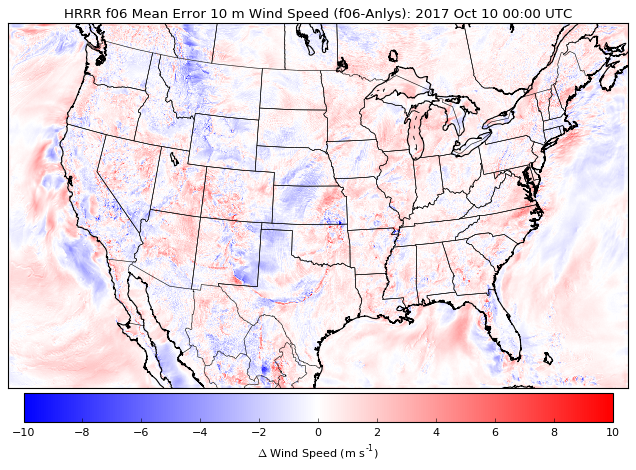

In [21]:
# To match the valid time for the forecast fxx and the analysis, 
#   we'll need to subtract the number of forecast hours from the analysis date.
DATE = datetime(2017, 10, 10, 0)
fxx = 6

# HRRR Analysis
Hu = get_hrrr_variable(DATE, variable='UGRD:10 m')
Hv = get_hrrr_variable(DATE, variable='VGRD:10 m')

# HRRR Forecast
Hfu = get_hrrr_variable(DATE-timedelta(hours=fxx), variable='UGRD:10 m', fxx=fxx)
Hfv = get_hrrr_variable(DATE-timedelta(hours=fxx), variable='VGRD:10 m', fxx=fxx)

print Hu['msg'], Hu['valid']
print Hfu['msg'], Hfu['valid']

# Calculate the difference between the HRRR analysis and HRRR forecast (fxx-anlys)
#   so that the red shows where the forecast is fast and blue shows where forecast
#   is slow.
aSPD = wind_uv_to_spd(Hu['value'], Hv['value'])
fSPD = wind_uv_to_spd(Hfu['value'], Hfv['value'])
diff = fSPD-aSPD

m.pcolormesh(H['lon'], H['lat'], diff, 
             latlon=True, cmap='bwr',
             vmax=10, vmin=-10)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label(r'$\Delta$ Wind Speed (m s$\mathregular{^{-1}}$)')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('HRRR f%02d Mean Error 10 m Wind Speed (f%02d-Anlys): %s' % (fxx, fxx, H['valid'].strftime('%Y %b %d %H:%M UTC')))

## Basemap Subplots
Plot two maps side by side

./temp_2017101000_f00_DPT.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 57:36754446:d=2017101000:DPT:2 m above ground:anl

range: 36754446 37898952
./temp_2017101000_f00_TMP.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 54:32968209:d=2017101000:TMP:2 m above ground:anl

range: 32968209 34215398


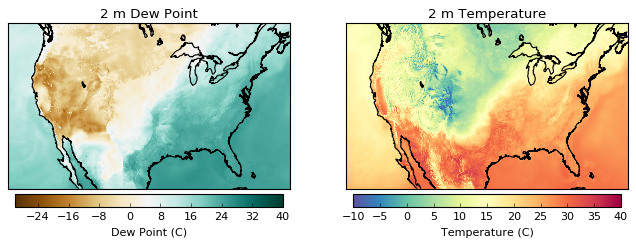

In [42]:
H1 = get_hrrr_variable(DATE, variable='DPT:2 m')
H2 = get_hrrr_variable(DATE, variable='TMP:2 m')

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

plt.sca(ax1)
m.drawcoastlines()
m.pcolormesh(H['lon'], H['lat'], H1['value']-273.15, 
             latlon=True, cmap='BrBG',
             vmax=40, vmin=-30)
ax1.set_title('2 m Dew Point')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('Dew Point (C)')


plt.sca(ax2)
m.drawcoastlines()
m.pcolormesh(H['lon'], H['lat'], H2['value']-273.15, 
             latlon=True, cmap='Spectral_r',
             vmax=40, vmin=-10)
ax2.set_title('2 m Temperature')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('Temperature (C)')


#### Terrain Gradient and Hillshade


In [6]:
H = get_hrrr_variable(DATE, variable='HGT:surface')

./temp_2018012200_f00_HGT.grib2

-----------------------------------------------------------------------
!! Hey! You are requesting a date that is not on the Pando archive  !!
!! That's ok, I'll redirect you to the NOMADS server. :)            !!
-----------------------------------------------------------------------

matched a variable 46:29093742:d=2018012200:HGT:surface:anl:

range: 29093742 31330090


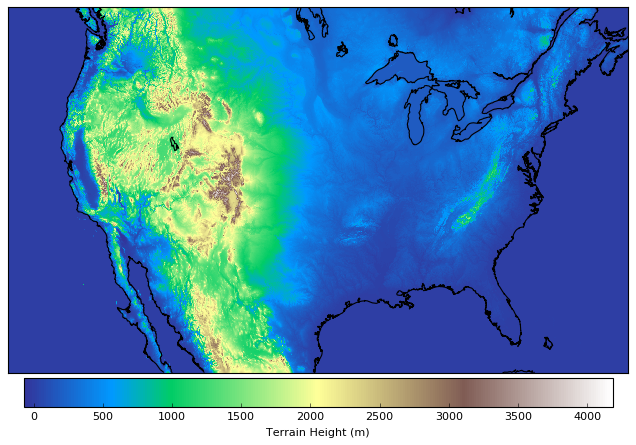

In [22]:
m.drawcoastlines()
m.pcolormesh(H['lon'], H['lat'], H['value'], 
             latlon=True, cmap='terrain')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('Terrain Height (m)')

In [33]:
gradient = np.gradient(H['value'], 3, 3)

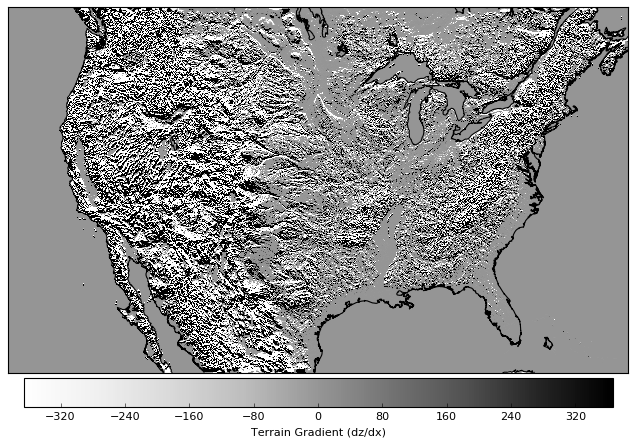

In [93]:
m.drawcoastlines()
m.pcolormesh(H['lon'], H['lat'], gradient[0]**5,  # scale by power of 5 to make features stick out
             latlon=True, cmap='Greys',
             vmax=366, vmin=-366)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('Terrain Gradient (dz/dx)')

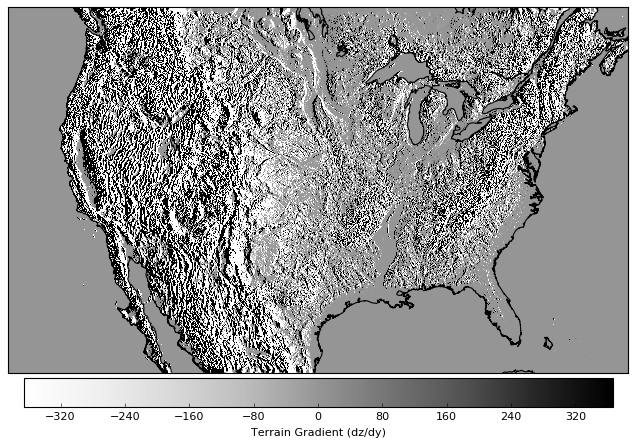

In [92]:
m.drawcoastlines()
m.pcolormesh(H['lon'], H['lat'], gradient[1]**5, # scale by power of 5 to make features stick out
             latlon=True, cmap='Greys',
             vmax=366, vmin=-366)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('Terrain Gradient (dz/dy)')

In [ ]:
# Hillshade Shading: https://github.com/rveciana/geoexamples/blob/master/python/shaded_relief/shaded_relief.py 
azimuth = 315
angle_altitude=45

x, y = np.gradient(H['value'], 3, 3)
slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
aspect = np.arctan2(-x, y)
azimuthrad = azimuth * np.pi / 180.
altituderad = angle_altitude * np.pi / 180.

shaded = np.sin(altituderad) * np.sin(slope)\
       + np.cos(altituderad) * np.cos(slope)\
       * np.cos(azimuthrad - aspect)
        

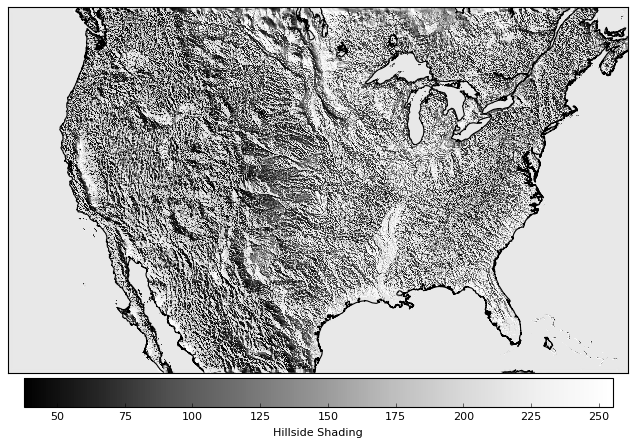

In [126]:
m.drawcoastlines()
m.pcolormesh(H['lon'], H['lat'], 255*(shaded+1)/2, # scale by power of 5 to make features stick out
             latlon=True, cmap='Greys_r')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=0.95)
cb.set_label('Hillside Shading')